*This notebook bring everything together, we attempt to compare the sentiment data off reddit with the atlas data which we collect*

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os 
import pandas as pd

text_bodies = []
data_directory = './Labeled_Sentiment'
for filename in os.listdir(data_directory):
    f = os.path.join(data_directory, filename)
    if os.path.isfile(f):
        parser_df = pd.read_csv(f, keep_default_na=False, sep=',')
        for index, row in parser_df.iterrows():
            if 'body' in row:
                text_bodies.append(row['body'])
            elif 'title_text_combined' in row:
                text_bodies.append(row['title_text_combined'])
            else:
                print (f'Row {index} has no body or title_text_combined row!')
            if not isinstance(text_bodies[-1], str):
                print (row)
                print (len(text_bodies))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We will not parse the files in the data directory, and store the resulting text bodies in text_bodies. For comments, we add the column 'body' and for posts we add the column 'title_text_combined'

In [143]:
import pandas as pd
from Sentiment_Analysis.sentiment_enum import LABEL_TO_NUM
import math

data = pd.read_csv('./labeled_sentiment/comments_with_sentiment.csv')

sentiment_labels = []
failed = 0
for i in range(len(data)):
    try:
        pred_label = LABEL_TO_NUM[data['predicted_label'][i]]
        # if float(data['score'][i] == 0):
        #     log_val = 0
        # else:
        #     log_val = math.log(abs(float(data['score'][i])))

        # if float(data['score'][i]) < 0:
        #     sentiment_label =  - log_val * pred_label
        # elif float(data['score'][i]) > 0:
        #     sentiment_label =  log_val * pred_label
        # else:
        #     sentiment_label = 0
        
        sentiment_labels.append(pred_label + float(data['score'][i]) * 0.1 * pred_label)
    except Exception as e:
        sentiment_labels.append(0)
        failed += 1

print (f'Failed on {failed} sentiment labels.')
print (f'Length of dataset: {len(sentiment_labels)}')

Failed on 712 sentiment labels.
Length of dataset: 239422


We will now run entity extraction on the text_bodies list, and store the entities for each post/comment into entity_labels

In [110]:
from Entity_Extraction.entity_extraction import EntityExtractor
entityExtractor = EntityExtractor()
entity_labels = entityExtractor.batch_extract(text_bodies)

ModuleNotFoundError: No module named 'department_names'

In [144]:
import pandas as pd

data = pd.read_csv('./Entity_Extraction/entities.csv')

entity_labels = []
failed = 0
for i in range(len(data)):
    entity_label = data['entity'][i]
    if entity_label == 'NONE':
        entity_labels.append([])
    else:
        entity_labels.append([entity_label])

print (f'Length of dataset: {len(entity_labels)}')

Length of dataset: 239422


Now, we will assign average sentiment to each entity. We first match each entity with the sentiment of all posts it is seen in. Then, we calculate an average for the sentiment of that label.

In [145]:
entity_sentiment_dict = dict()
for index in range(len(sentiment_labels)):
    temp_entities = entity_labels[index]
    temp_sentiment = sentiment_labels[index]

    for e in temp_entities:
        if e not in entity_sentiment_dict:
            entity_sentiment_dict[e] = []
        entity_sentiment_dict[e].append(temp_sentiment)

to_del = []
for e in entity_sentiment_dict:
    new_e_s = []
    for x in entity_sentiment_dict[e]:
        if x != 0:
            new_e_s.append(x)
    if len(new_e_s) == 0:
        to_del.append(e)
    else:
        entity_sentiment_dict[e] = \
            (len(new_e_s), sum(new_e_s)/len(new_e_s))
for i in to_del:
    del entity_sentiment_dict[i]

Run the following two cells to get some summaries of the data and a sense of what they contain

In [146]:
entity_sentiment_arr = sorted(entity_sentiment_dict.items(), key=lambda x:x[1][1])
[x for x in entity_sentiment_arr if x[1][0] >= 10]

[('EECS 496', (57, -1.9070175438596493)),
 ('CHEM 216', (16, -1.6)),
 ('BE 100', (34, -1.2088235294117649)),
 ('EECS 477', (16, -0.7625000000000001)),
 ('PHYSICS 235', (25, -0.7080000000000001)),
 ('EECS 484', (35, -0.5685714285714286)),
 ('ECON 251', (15, -0.5666666666666667)),
 ('MATH 216', (105, -0.5647619047619048)),
 ('MATH 215', (201, -0.551741293532338)),
 ('ASTRO 102', (22, -0.5045454545454549)),
 ('EECS 376', (320, -0.35468750000000004)),
 ('STATS 280', (16, -0.33125000000000004)),
 ('EECS 370', (391, -0.3153452685421997)),
 ('EECS 381', (25, -0.2879999999999999)),
 ('CHEM 215', (73, -0.28493150684931523)),
 ('MATH 105', (21, -0.27619047619047626)),
 ('MATH 465', (15, -0.2000000000000001)),
 ('ECON 102', (29, -0.17931034482758623)),
 ('EECS 467', (18, -0.1777777777777777)),
 ('ECON 401', (61, -0.17704918032786893)),
 ('STATS 250', (524, -0.14866412213740451)),
 ('SPANISH 231', (12, -0.12499999999999996)),
 ('BIO 305', (17, -0.08235294117647053)),
 ('STATS 306', (13, -0.0769230

In [147]:
entity_sentiment_arr = sorted(entity_sentiment_dict.items(), key=lambda x:x[1][1], reverse=True)
([x for x in entity_sentiment_arr if x[1][0] >= 10])

[('HISTORY 244', (11, 1.7545454545454546)),
 ('PHIL 183', (14, 1.7000000000000004)),
 ('PAT 305', (16, 1.625)),
 ('EARTH 113', (17, 1.4588235294117649)),
 ('MATH 156', (13, 1.3461538461538463)),
 ('POLSCI 101', (11, 1.3454545454545455)),
 ('LING 111', (12, 1.2916666666666665)),
 ('SLAVIC 312', (24, 1.1041666666666667)),
 ('ENGLISH 325', (13, 1.0846153846153845)),
 ('SPACE 101', (16, 1.0312500000000002)),
 ('MATH 201', (14, 1.0000000000000002)),
 ('EECS 481', (16, 0.9624999999999997)),
 ('SOC 100', (14, 0.9214285714285715)),
 ('ARCH 357', (10, 0.8699999999999999)),
 ('PHYSICS 360', (12, 0.8416666666666667)),
 ('GERMAN 386', (21, 0.819047619047619)),
 ('SI 206', (11, 0.8181818181818182)),
 ('CLCIV 385', (20, 0.805)),
 ('MATH 120', (12, 0.7583333333333334)),
 ('ASTRO 101', (30, 0.7566666666666664)),
 ('EARTH 100', (12, 0.7416666666666666)),
 ('SI 410', (10, 0.72)),
 ('EECS 475', (25, 0.66)),
 ('EECS 201', (33, 0.6121212121212123)),
 ('PSYCH 111', (40, 0.5874999999999998)),
 ('MATH 295', (

Find the list of courses with at least 50 appearances

In [181]:
print([x[0] for x in entity_sentiment_arr if x[1][0] >= 10])
print(len([x[0] for x in entity_sentiment_arr if x[1][0] >= 10]))

['HISTORY 244', 'PHIL 183', 'PAT 305', 'EARTH 113', 'MATH 156', 'POLSCI 101', 'LING 111', 'SLAVIC 312', 'ENGLISH 325', 'SPACE 101', 'MATH 201', 'EECS 481', 'SOC 100', 'ARCH 357', 'PHYSICS 360', 'GERMAN 386', 'SI 206', 'CLCIV 385', 'MATH 120', 'ASTRO 101', 'EARTH 100', 'SI 410', 'EECS 475', 'EECS 201', 'PSYCH 111', 'MATH 295', 'EECS 270', 'BIO 225', 'EECS 285', 'MCDB 310', 'EECS 486', 'EECS 493', 'MATH 425', 'PHYSICS 140', 'ENGR 100', 'PHIL 340', 'SI 110', 'IOE 265', 'SI 106', 'ASTRO 106', 'EECS 491', 'EECS 183', 'ENGR 151', 'BIO 207', 'EECS 490', 'MATH 285', 'PSYCH 230', 'STATS 426', 'CHEM 260', 'EECS 301', 'ECON 101', 'EECS 494', 'ANTHRO 101', 'MATH 185', 'EECS 485', 'ENGR 110', 'EECS 442', 'ENGLISH 125', 'EECS 445', 'MATH 316', 'EECS 388', 'CHEM 211', 'MATH 412', 'PHYSICS 240', 'CHEM 230', 'EECS 492', 'MATH 217', 'MATH 116', 'ANTHRCUL 101', 'PSYCH 240', 'CHEM 210', 'EECS 489', 'EECS 216', 'BIO 172', 'EECS 215', 'CHEM 125', 'STATS 425', 'PHYSICS 340', 'ENGR 101', 'BIO 171', 'MATH 214'

Test the sentiment against increased interest

In [249]:
import json
 
with open('Atlas/Atlas_Data_2.json') as json_file:
    atlas_data_json = json.load(json_file)

class_order = list(atlas_data_json.keys())
combined_data = {'expectations':[], 'desire':[], 'increased-interest':[], 'understanding':[], 'average':[], 'workload':[],'sentiment':[]}
for c in class_order:
    if entity_sentiment_dict[c][0] >= 10:
        temp_av = 0
        for dt in atlas_data_json[c]:
            if dt in ['desire', 'increased-interest', 'understanding']:
                temp_av += atlas_data_json[c][dt] * 0.01
            combined_data[dt].append(0.01 * atlas_data_json[c][dt])
        combined_data['average'].append(temp_av)
        combined_data['sentiment'].append(entity_sentiment_dict[c][1])

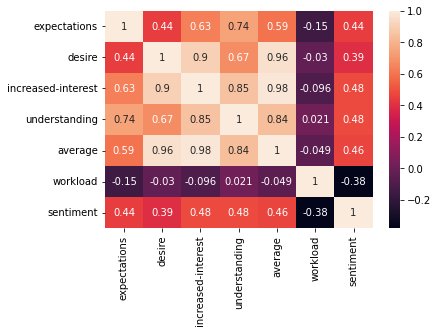

In [250]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df = pd.DataFrame(combined_data)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

0.23170974258029275
(0.05673185865410193, 0.8721638952105877)


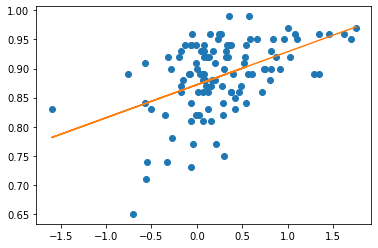

In [251]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

x_points = np.array(combined_data['sentiment'])
y_points = np.array(combined_data['understanding'])
x_new = x_points.reshape(-1, 1)
y_new = y_points.reshape(-1, 1)

plt.plot(x_points, y_points, 'o')

# reg = linear_model.RANSACRegressor(random_state=0).fit(x_new, y_new)
# line_X = np.arange(x_new.min(), x_new.max())[:, np.newaxis]
# line_y_ransac = reg.predict(line_X)
# plt.plot(
#     line_X,
#     line_y_ransac,
#     color="red",
#     label="RANSAC regressor",
# )
# reg2 = linear_model.LogisticRegression(random_state=0).fit(x_new, y_points)
# ys = np.array([reg2.predict(x) for x in range(0,1,0.01)])
# plt.plot(x_points, reg2.predict(x_points))
m, b = np.polyfit(x_points, y_points, 1)
plt.plot(x_points, m*x_points+b)
from sklearn.metrics import r2_score
print(r2_score(y_points, np.poly1d((m, b))(x_points)))
print ((m,b))
plt.show()


In [189]:
import numpy as np
s = np.array(combined_data['sentiment'])
a = np.array(combined_data['understanding'])
fit = np.polyfit(s, a, 3)
np.polyval(fit, s)

array([0.94417248, 0.94490037, 0.94543247, 0.9447908 , 0.94303446,
       0.94302044, 0.94183099, 0.93607896, 0.93534557, 0.93322498,
       0.9319051 , 0.93024811, 0.92834515, 0.92583823, 0.92440076,
       0.92322559, 0.92318013, 0.92248373, 0.91986331, 0.91902938,
       0.91780814, 0.91432798, 0.91145366, 0.90994422, 0.90889569,
       0.90876065, 0.90687194, 0.90664559, 0.90581613, 0.90385525,
       0.90238106, 0.89941667, 0.89918394, 0.89784944, 0.89662842,
       0.89662842, 0.89659015, 0.89460064, 0.89455077, 0.8939073 ,
       0.89282751, 0.89230111, 0.89105081, 0.89105081, 0.89036074,
       0.8902388 , 0.88915149, 0.88834888, 0.88708665, 0.88621181,
       0.88516438, 0.88408388, 0.88388292, 0.88235246, 0.88173406,
       0.88103204, 0.88094841, 0.88055518, 0.87962286, 0.87890096,
       0.8786924 , 0.8775412 , 0.87695745, 0.87616849, 0.87568316,
       0.87542362, 0.87517478, 0.87504752, 0.87497115, 0.8746317 ,
       0.87383935, 0.87289417, 0.87118608, 0.87057178, 0.87019

In [190]:
np.corrcoef(s, a)

array([[1.        , 0.48287651],
       [0.48287651, 1.        ]])